## Aplicando modelo **Regressão Linear Simples**

In [12]:
# confirgurando diretório
import os
os.chdir("..")

# importando bibliotecas
import warnings 
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from main.evaluation import Evaluation
from main.plots import plot_hist
from utilsforecast.plotting import plot_series
from matplotlib import pyplot as plt

# configurando notebook
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

plt.style.use(['ggplot'])

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
## leitura dos dados
train_df = pd.read_csv("nbs/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("nbs/data/test_df.csv", parse_dates=['ds'])

FileNotFoundError: [Errno 2] No such file or directory: 'nbs/data/train_df.csv'

In [5]:
# modelo ingênuo - usa apenas a sequência como variável explicativa
def linear_regression(df):
    train = df.copy().reset_index(drop=True)
    unique_id = train.unique_id[0]
    test = test_df[test_df['unique_id'] == unique_id].reset_index(drop=True)
    test.index = test.index + train.index.max()

    m = LinearRegression()
    m.fit(
        X=train.index.values.reshape(-1,1), y=train.y
    )
    test['predicted'] = m.predict(X=test.index.values.reshape(-1,1))

    return test

In [6]:
# aplicando modelo para cada série
fcst_df = train_df.groupby("unique_id").apply(linear_regression).reset_index(drop=True)

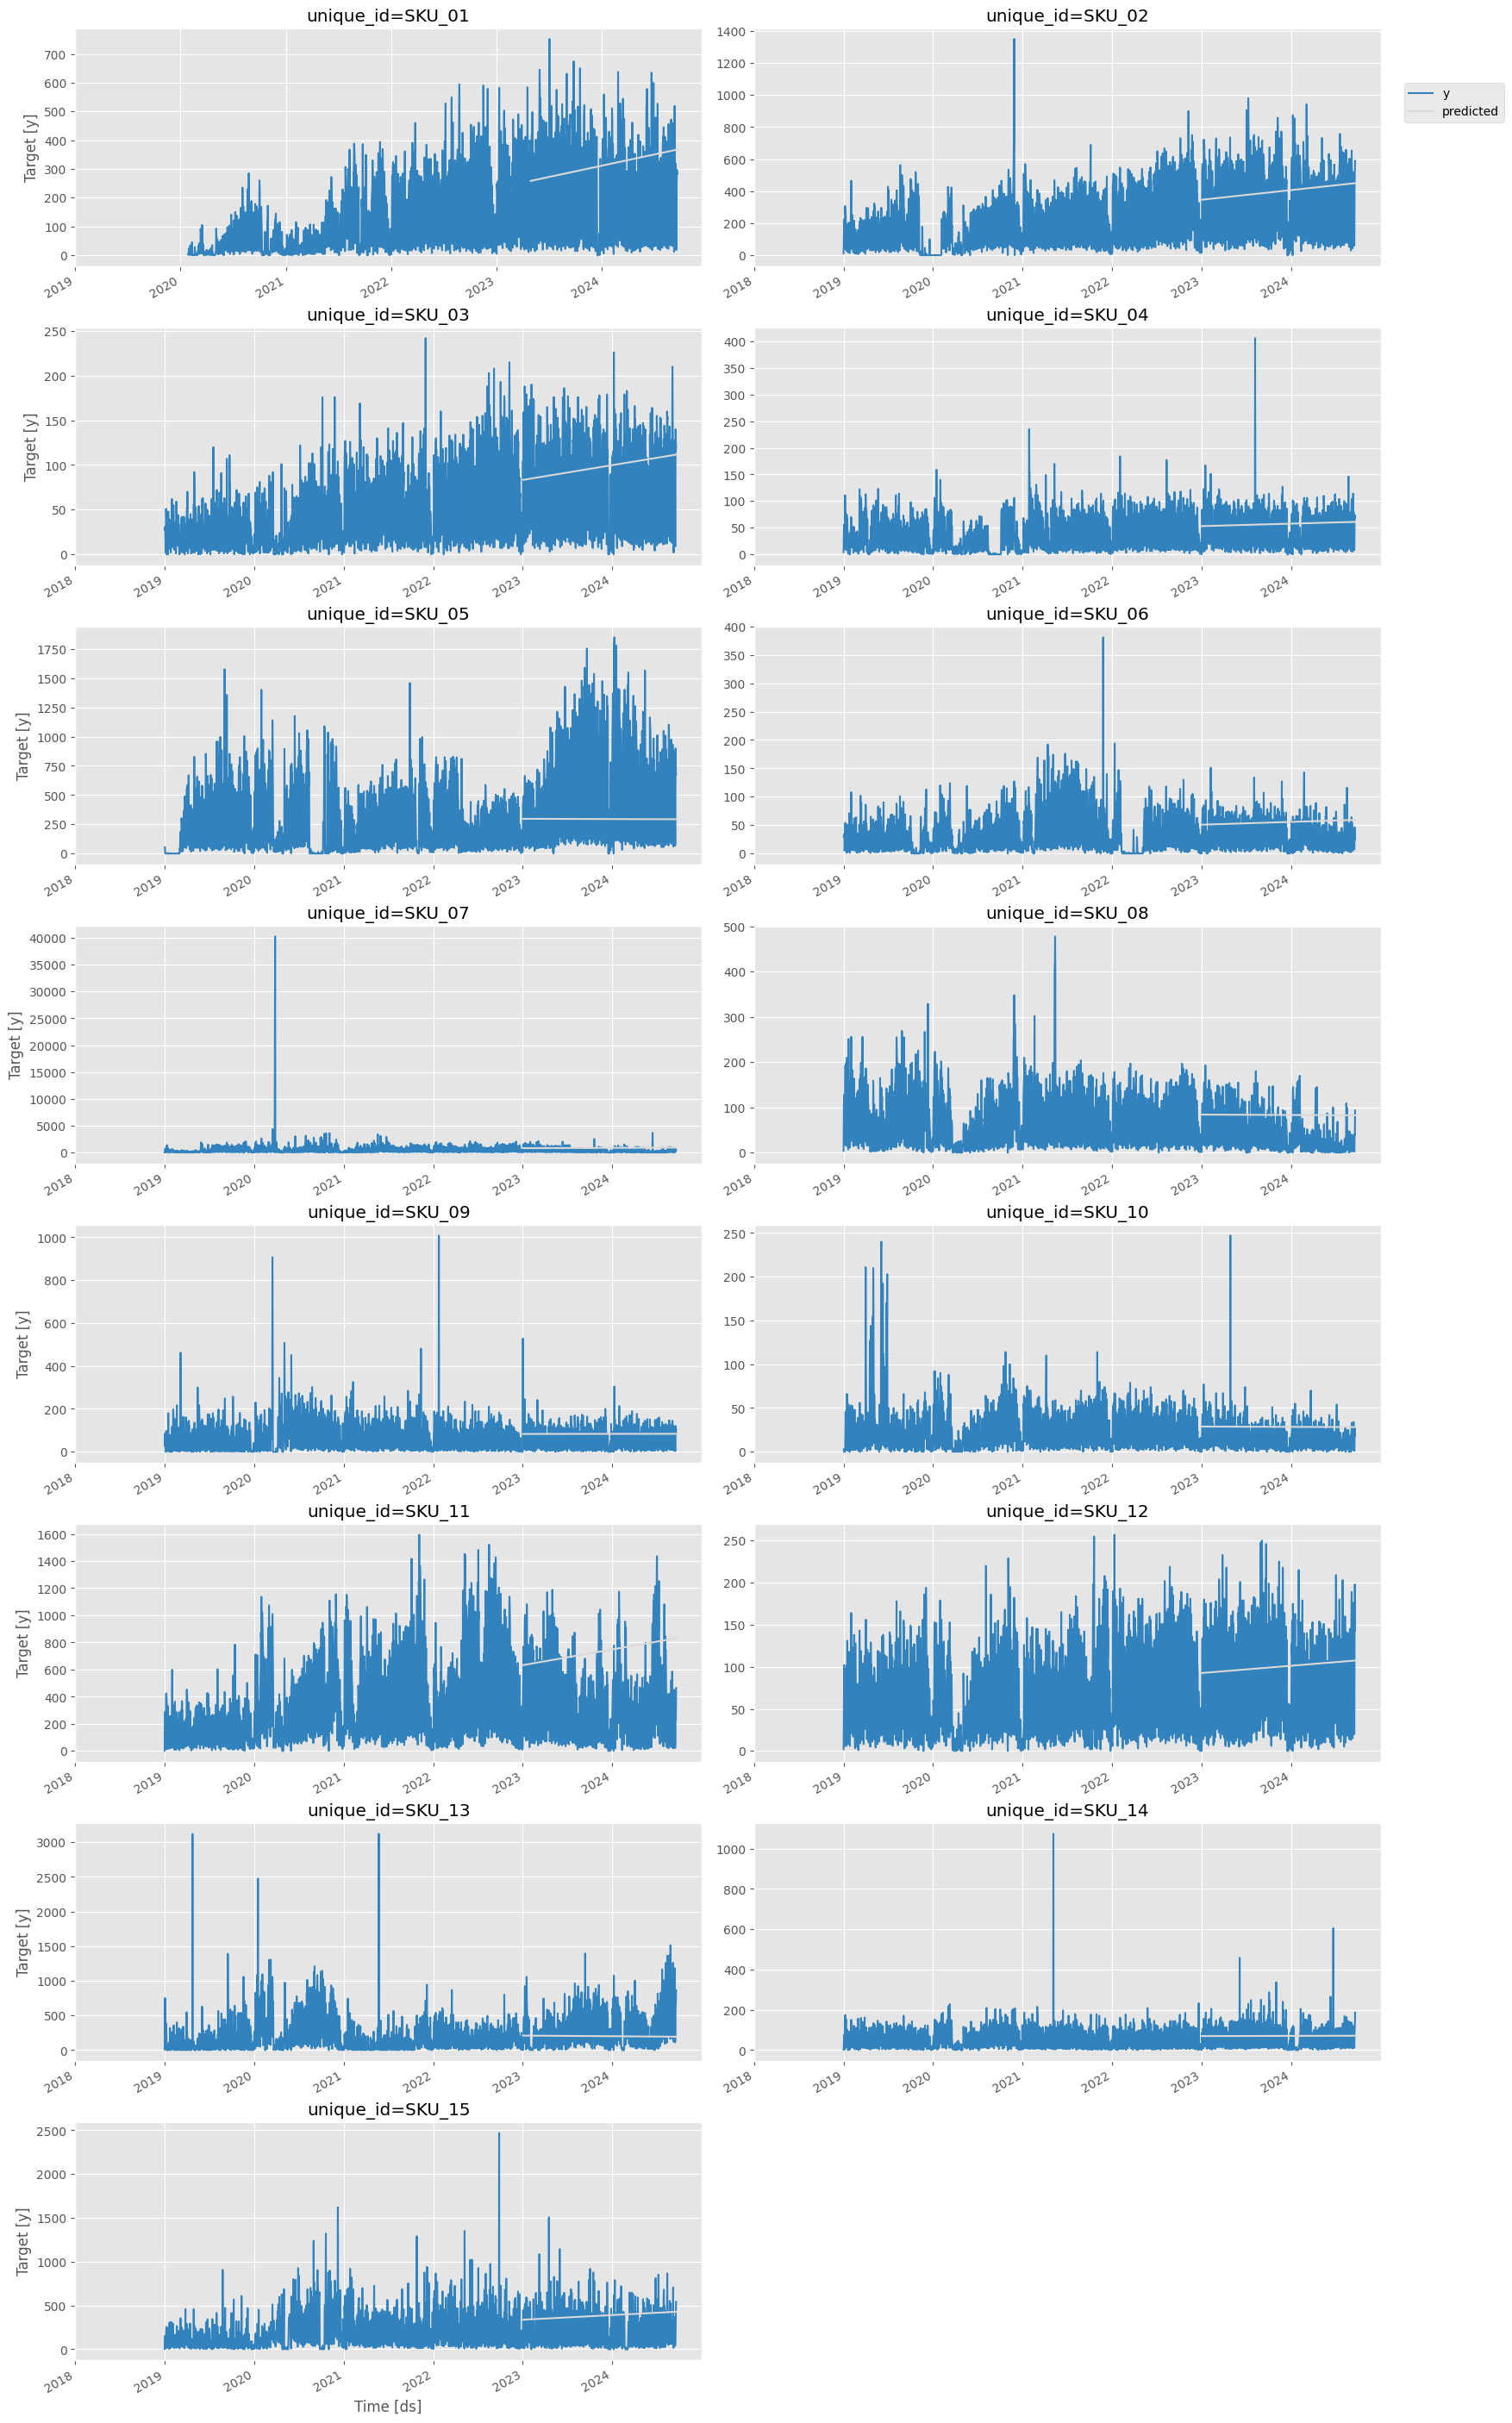

In [7]:
# plot dos forecasts 
plot_series(df=train_df, forecasts_df=fcst_df, max_ids=15, palette='tab20c')

In [8]:
# métricas de desempenho
f = lambda x: Evaluation(x['y'], x['predicted']).summary()
fcst_df.groupby("unique_id").apply(f)

,,MAE,MSE,RMSE,R2
unique_id,,,,,
SKU_01,0,155.87,35460.10,188.31,-0.16
SKU_02,0,195.17,53654.73,231.63,-0.03
SKU_03,0,45.89,3087.54,55.57,-0.07
SKU_04,0,31.00,1454.88,38.14,-0.02
SKU_05,0,462.15,301882.66,549.44,-0.58
SKU_06,0,26.08,1027.54,32.06,-0.41
SKU_07,0,503.39,347957.47,589.88,-0.53
SKU_08,0,49.37,3081.35,55.51,-0.38
SKU_09,0,42.67,3022.21,54.97,-0.03


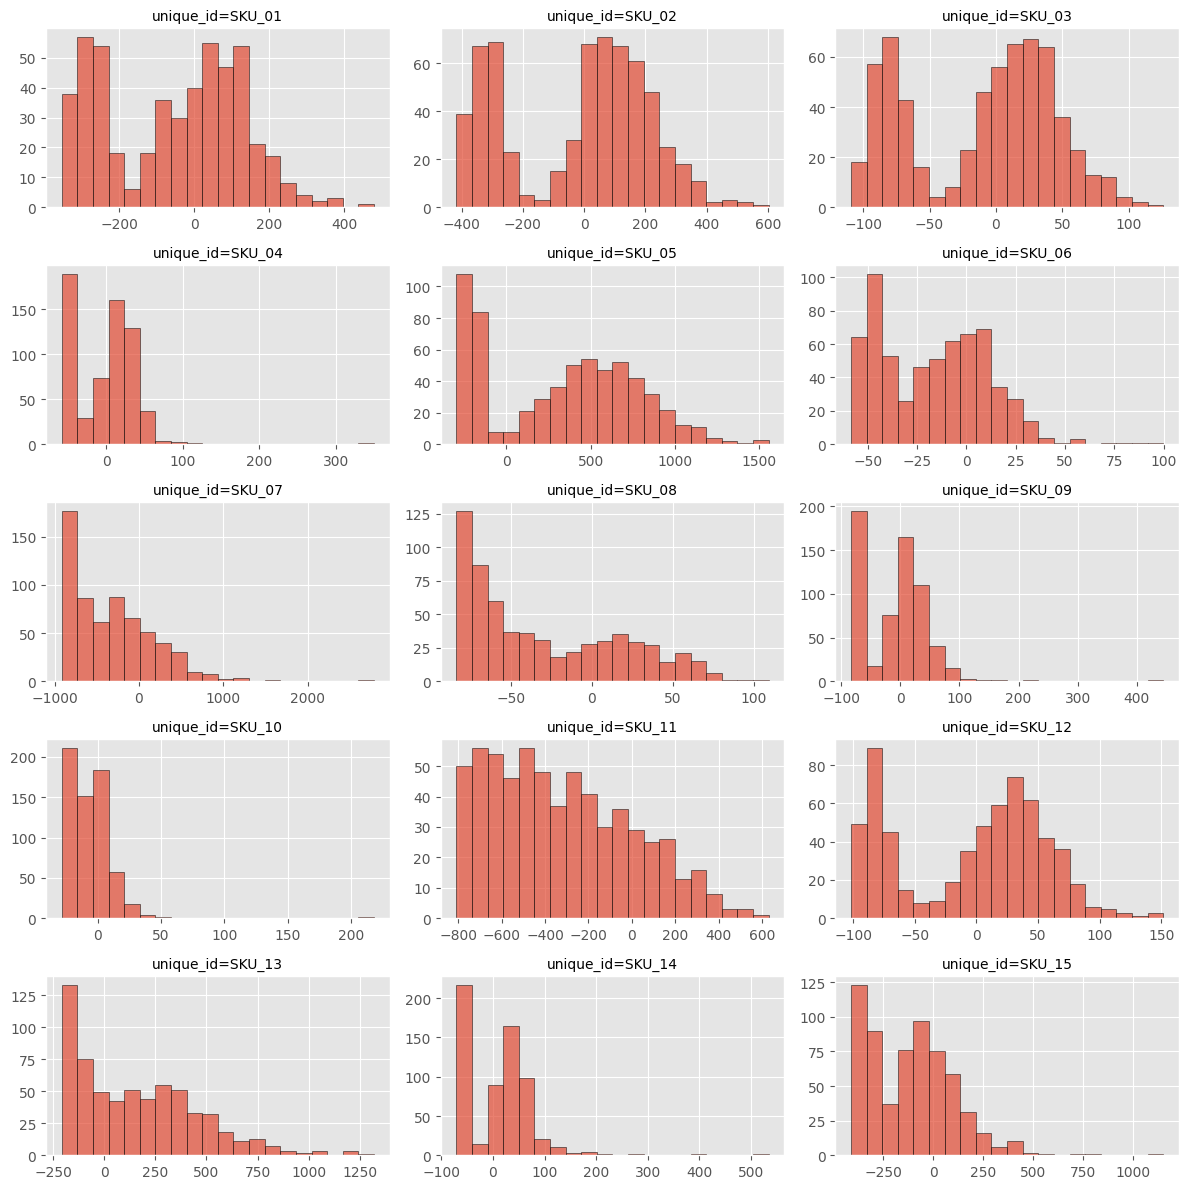

In [10]:
# plot dos resíduos do modelo
plot_hist(
    df=fcst_df.assign(residual = lambda x: x['y'] - x['predicted']),
    id_col='unique_id',
    data_col=['residual'],
    ids=fcst_df.unique_id.unique(),
    grid=(5, 3),
    figsize=(12,12)
)

In [ ]:
# TODO: criar variáveis exógenas adequadas para capturar a sazonalidade

In [20]:
train_df['day'] = train_df.ds.dt.day_of_year
train_df['year'] = train_df.ds.dt.year
train_df['quarter'] = train_df.ds.dt.quarter

In [21]:
train_df

,unique_id,ds,y,day,year,quarter
0,SKU_01,2020-01-28,4.00,28,2020,1
1,SKU_01,2020-01-29,1.00,29,2020,1
2,SKU_01,2020-01-30,19.00,30,2020,1
3,SKU_01,2020-01-31,23.00,31,2020,1
4,SKU_01,2020-02-01,4.00,32,2020,1
...,...,...,...,...,...,...
21645,SKU_15,2022-12-28,128.00,362,2022,4
21646,SKU_15,2022-12-29,166.00,363,2022,4
21647,SKU_15,2022-12-30,19.00,364,2022,4
21648,SKU_15,2022-12-31,18.00,365,2022,4
